p# Raster to Grid Interpolation

## Creat an area and a grid (Rio Primero) with rotation

In [1]:
from morpheus.project.types.discretization.spatial import Rotation, Grid
from morpheus.project.types.geometry import Polygon

area = Polygon([[(-63.70070096929353, -31.341995008370162),
                 (-63.59062809221137, -31.28770219420632),
                 (-63.55589503070645, -31.33909863389222),
                 (-63.66596790778863, -31.393361805793646),
                 (-63.70070096929353, -31.341995008370162)]])

grid = Grid.cartesian_from_polygon(
  polygon=area,
  n_cols=20,
  n_rows=20,
  rotation=Rotation(30),
)

import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(area.as_geojson()))
m.add_child(folium.GeoJson(grid.origin.as_geojson()))

n_cols = grid.n_cols()
n_rows = grid.n_rows()
cell_geometries = grid.get_wgs_cell_geometries()

for col in range(n_cols):
  for row in range(n_rows):
    if col == 0 and row == 0:
      continue
    cell_geometry = cell_geometries[row][col]
    folium.GeoJson(cell_geometry.as_geojson()).add_to(m)

m.fit_bounds(m.get_bounds())
m

## Draw a BoundingBox around the model area

In [2]:
area.bbox()

[-63.70070096929353,
 -31.393361805793646,
 -63.55589503070645,
 -31.28770219420632]

In [3]:
min_x, min_y, max_x, max_y = area.bbox()
bounding_box_polygon = Polygon([[
  (min_x, min_y),
  (min_x, max_y),
  (max_x, max_y),
  (max_x, min_y),
  (min_x, min_y)
]])
m.add_child(folium.GeoJson(bounding_box_polygon.as_geojson()))
m

## Create a raster

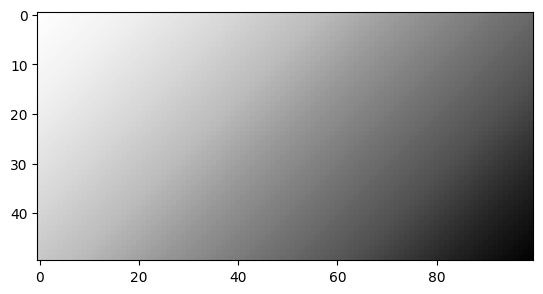

In [4]:
import numpy as np
import matplotlib.pyplot as plt

raster_x = np.linspace(min_x, max_x, 100)
raster_y = np.linspace(min_y, max_y, 50)

raster_data = np.zeros((len(raster_y), len(raster_x)))
for i, y in enumerate(raster_y):
  for j, x in enumerate(raster_x):
    raster_data[i, j] = i + j

plt.imshow(raster_data, origin='upper', cmap='Greys', vmin=0, vmax=150)

## Interpolate the raster to the grid and plot the result

In [5]:
from morpheus.project.infrastructure.assets.RasterInterpolationService import RasterData, RasterInterpolationService

interpolation_service = RasterInterpolationService()

input_raster_xx, input_raster_yy = np.meshgrid(raster_x, raster_y)
input_raster_data = RasterData(
    xx_centers=input_raster_xx,
    yy_centers=input_raster_yy,
    bounds=grid.get_wgs_bbox(),
    data=raster_data,
    nodata_value=-9999.0
)

output_coords = grid.get_wgs_cell_centers()
output_raster_data, no_data_value = interpolation_service.raster_data_to_grid_data(
  raster_data=input_raster_data,
  grid=grid,
  method='linear',
  no_data_value=-9999.0
)

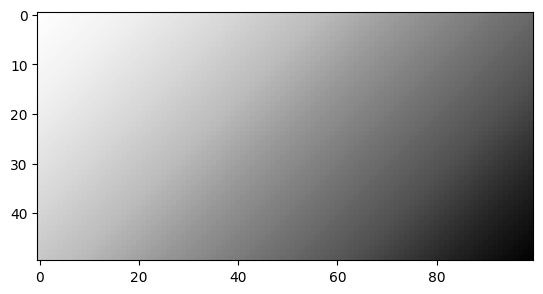

In [6]:
plt.imshow(input_raster_data.get_data(), origin='upper', cmap='Greys', vmin=0, vmax=150)

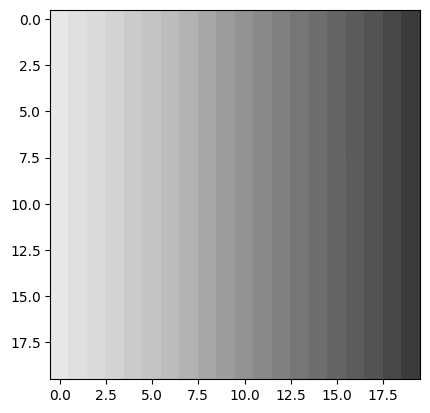

In [7]:
plt.imshow(output_raster_data, origin='upper', cmap='Greys', vmin=0, vmax=150)

## Reverse the interpolation

In [8]:
re_interpolated_raster_data = interpolation_service.grid_to_raster_data(
  grid=grid,
  data=output_raster_data,
  no_data_value=no_data_value,
)

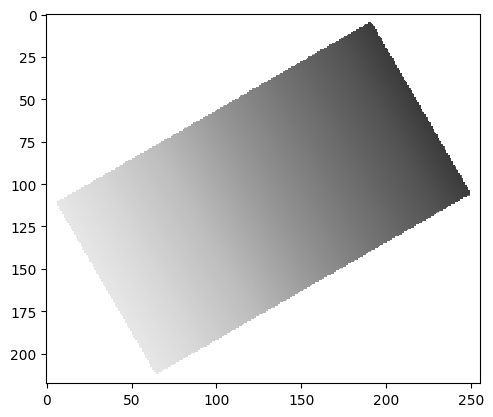

In [9]:
plt.imshow(re_interpolated_raster_data.get_data(), origin='upper', cmap='Greys', vmin=0, vmax=150)